### This script will make logo plots for each mAb against NiV

In [13]:
import math
import os

import altair as alt

import dms_variants.codonvarianttable

import numpy as np

import pandas as pd

import scipy.stats

import yaml

import Bio.SeqIO

import matplotlib

from Bio import PDB

import dmslogo
from dmslogo.colorschemes import CBPALETTE
from dmslogo.colorschemes import ValueToColorMap

In [14]:
# allow more rows for Altair
_ = alt.data_transformers.disable_max_rows()

if os.getcwd() == '/fh/fast/bloom_j/computational_notebooks/blarsen/2023/Nipah_Malaysia_RBP_DMS/':
    pass
    print("Already in correct directory")
else:
    os.chdir("/fh/fast/bloom_j/computational_notebooks/blarsen/2023/Nipah_Malaysia_RBP_DMS/")
    print("Setup in correct directory")
with open("config.yaml") as f:
    config = yaml.safe_load(f)

Setup in correct directory


In [35]:
func_scores = pd.read_csv('../Nipah_Malaysia_RBP_DMS/results/func_effects/averages/CHO_EFNB3_func_effects.csv')

In [36]:
display(func_scores)

site wildtype mutant  effect  effect_std  times_seen  n_selections
0        71        Q      * -4.6570     0.00000        23.0             2
1        71        Q      A -0.9095     1.14200         1.0             2
2        71        Q      C -0.5666     0.49200         5.0             2
3        71        Q      D -0.4219     0.08301         5.0             2
4        71        Q      E -0.8425     0.33870         4.0             2
...     ...      ...    ...     ...         ...         ...           ...
10756   603        *      *  0.0000     0.00000         NaN             2
10757   603        *      K -2.3820     0.00000         1.0             2
10758   603        *      Q -0.7298     0.84600         3.0             2
10759   603        *      W -0.8428     0.84460         2.0             2
10760   603        *      Y -1.7280     0.00000         1.0             2

[10761 rows x 7 columns]

### Read in each each antibody escape .csv

In [37]:
folder_path = '../Nipah_Malaysia_RBP_DMS/results/antibody_escape/averages/'
all_files = os.listdir(folder_path)
csv_files = [file for file in all_files if file.endswith('effect.csv')]
display(csv_files)

['HENV103_mut_effect.csv',
 'HENV117_mut_effect.csv',
 'nAH1.3_mut_effect.csv',
 'HENV32_mut_effect.csv',
 'm102.4_mut_effect.csv',
 'HENV26_mut_effect.csv',
 'minibinder_mut_effect.csv']

### Filter each antibody escape by times seen and functional score and save to a .csv for mapping colors onto structure. Also make logo plots

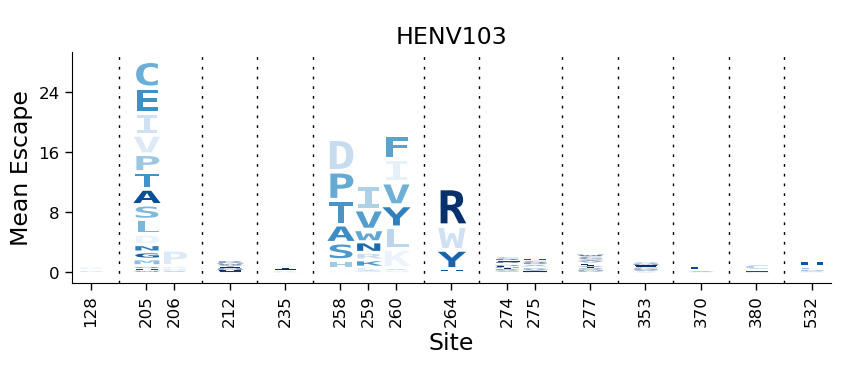

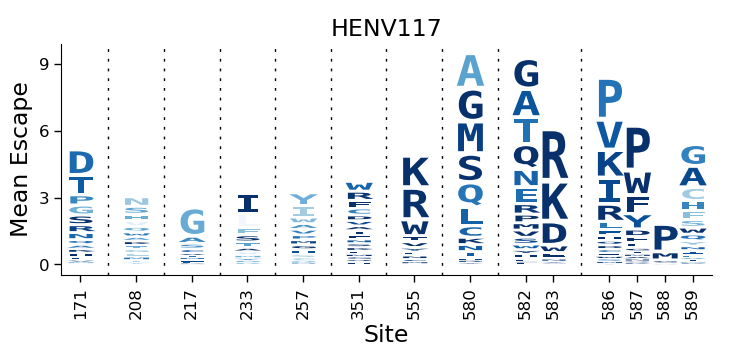

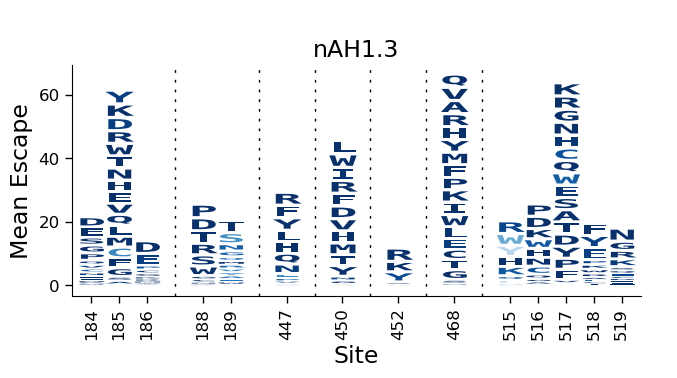

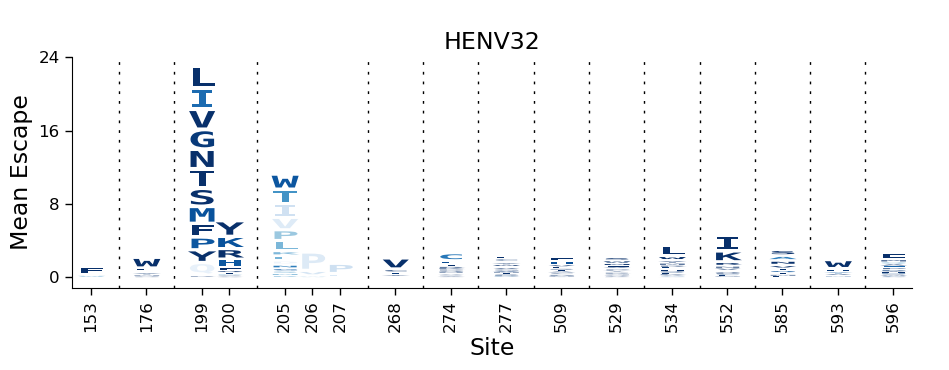

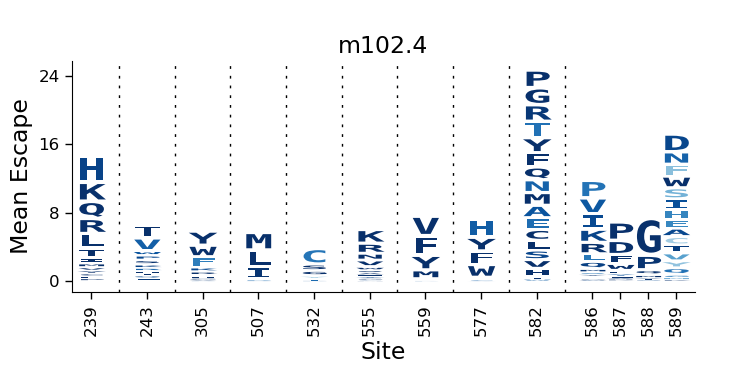

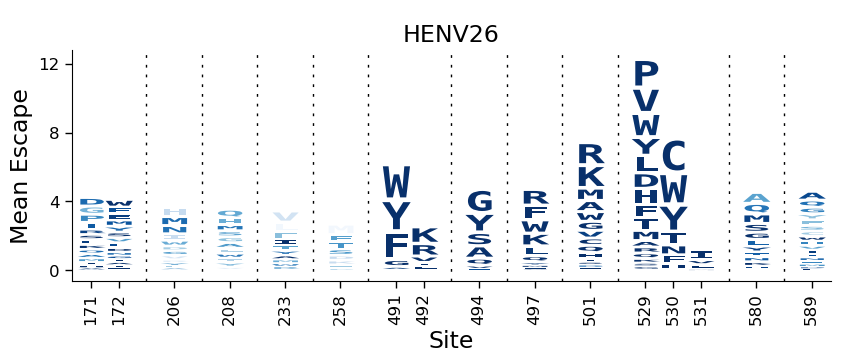

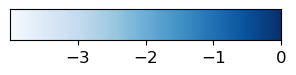

In [49]:
# Create directories
output_path = 'notebooks/outputs/filtered_escape_files/'
os.makedirs(output_path, exist_ok=True)
output_base_path = 'notebooks/outputs/logo_plots/'

def process_data(df, func_scores):
    """Filter and merge data according to given criteria."""
    df_merged = func_scores.merge(df, on=['site', 'mutant'])
    df_filtered = df_merged[
        (df_merged['mutant'] != '*') &
        (df_merged['times_seen_x'] >= 2) &
        (df_merged['times_seen_y'] >= 3) &
        (df_merged['n_models'] >= 2) &
        (df_merged['effect'] >= -4) &
        (df_merged['escape_std'] <= 2)
    ]
    return df_filtered

def generate_logo_plot(df, output_file, title):
    """Generate logo plot and save as a file."""
    fig, ax = dmslogo.draw_logo(
        data=df.query('show_site'),
        x_col='site',
        letter_col='mutant',
        letter_height_col='escape_mean',
        ylabel='Mean Escape',
        xlabel='Site',
        color_col='color',
        title=title
    )
    fig.savefig(output_file, bbox_inches='tight')

file_map = {
    'HENV103_mut_effect.csv': 'HENV103.pdf',
    'HENV117_mut_effect.csv': 'HENV117.pdf',
    'nAH1.3_mut_effect.csv': 'nAH1.3.pdf',
    'HENV32_mut_effect.csv': 'HENV32.pdf',
    'm102.4_mut_effect.csv': 'm102.4.pdf',
    'HENV26_mut_effect.csv': 'HENV26.pdf'
}

all_processed_dfs = {}
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    processed_df = process_data(df,func_scores)
    
    output_file_path = os.path.join(output_path, file)
    processed_df.to_csv(output_file_path, index=False)
    
    # Get sites with max score and aggregated sum over some percentile threshold
    sums_max = processed_df.groupby('site')['escape_mean'].max()
    quantile_max = sums_max.quantile(0.98)
    sites_max_score = sums_max[sums_max > quantile_max].index.tolist()

    sums_total = processed_df.groupby('site')['escape_mean'].sum()
    quantile_total = sums_total.quantile(0.98)
    sites_agg_sum = sums_total[sums_total > quantile_total].index.tolist()

    # Combine both lists of sites
    sites_to_show_list = list(set(sites_max_score + sites_agg_sum))
    processed_df['show_site'] = processed_df['site'].isin(sites_to_show_list)
    
    # Color by functional score and clip scores > 0
    processed_df['clip'] = np.clip(processed_df['effect'], None, 0)
    min_prop = processed_df['effect'].min()
    max_prop = processed_df['clip'].max()

    map1 = ValueToColorMap(minvalue=min_prop, maxvalue=max_prop, cmap='Blues')
    processed_df['color'] = processed_df['clip'].map(map1.val_to_color)

    # Filter data based on max escape value for each antibody
    #max_escape = processed_df['escape_mean'].max() * 0.2
    #print(max_escape)
    #processed_df = processed_df[processed_df['escape_mean'] >= max_escape]
    processed_df = processed_df[processed_df['escape_mean'] >= 0]
    all_processed_dfs[file] = processed_df.copy()

    # Generate logo plot for specified files
    if file in file_map:
        output_file = os.path.join(output_base_path, file_map[file])
        generate_logo_plot(processed_df, output_file, file.replace('_mut_effect.csv', ''))

fig, _ = map1.scale_bar(orientation='horizontal')
fig.savefig(os.path.join(output_base_path, 'scalebar.pdf'), bbox_inches='tight')

### Now Process the filtered data frames from above for each antibody and plot bubble plots

In [45]:
order_ab = ['m102.4','HENV-26','HENV-117','HENV-103','HENV-32','nAH1.3']

def filter_and_label_dfs(all_processed_dfs):
    """
    Filter processed dataframes and label sources.
    
    Args:
    - all_processed_dfs (dict): Dictionary with keys as source names and values as dataframes.

    Returns:
    - DataFrame: A combined dataframe with filtered entries and labeled sources.
    """
    filtered_dfs = []

    # Filter and label each dataframe based on its source
    for key, df in all_processed_dfs.items():
        filtered_df = df[df['show_site']].copy()  # Filter by 'show_site' column
        filtered_df['source'] = key  # Add a column indicating the source
        filtered_dfs.append(filtered_df)

    # Combine all dataframes
    combined_df = pd.concat(filtered_dfs, ignore_index=True)
    
    # Filter out specific entries
    combined_df = combined_df[combined_df['source'] != 'minibinder_mut_effect.csv']

    # Map source names to custom labels
    custom_labels = {
        'HENV103_mut_effect.csv': 'HENV-103',
        'HENV117_mut_effect.csv': 'HENV-117',
        'nAH1.3_mut_effect.csv': 'nAH1.3',
        'HENV32_mut_effect.csv': 'HENV-32',
        'm102.4_mut_effect.csv': 'm102.4',
        'HENV26_mut_effect.csv': 'HENV-26'
    }
    combined_df['custom_source'] = combined_df['source'].map(lambda x: custom_labels.get(x, x))
    
    return combined_df

def generate_chart(data):
    """
    Generate an Altair chart based on the given data.

    Args:
    - data (DataFrame): The data to visualize.

    Returns:
    - Chart: The final Altair chart.
    """
    variant_selector = alt.selection_point(
    on="mouseover",
    empty=False,
    fields=["site"],
    value=1
    )
    
    chart = alt.Chart(data).mark_point(filled=True, opacity=0.3).encode(
        x=alt.X('custom_source:O',sort=order_ab, title='Antibody', axis=alt.Axis(labelAngle=-45)),
        y=alt.Y('effect:Q', title='Functional Effect of Escape Mutants', axis=alt.Axis(grid=False, tickCount=4)),
        size=alt.Size('escape_mean', legend=alt.Legend(title='Mean Escape By Mutation')),
        xOffset='random:Q',
        tooltip=['source', 'effect', 'escape_median', 'escape_mean', 'site', 'mutant'],
        color=alt.Color('source').legend(None),
        #opacity=alt.condition(variant_selector, alt.value(1), alt.value(0.1)),
        #strokeWidth=alt.condition(variant_selector,alt.value(2),alt.value(0))
    ).transform_calculate(
        random="sqrt(-1*log(random()))*cos(2*PI*random())"
    ).properties(
        height=alt.Step(75),
        width=400
    )#.add_params(variant_selector)

    # Add a horizontal line at y=0
    horizontal_line = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule(color='black').encode(y='y:Q')
    
    # Combine the two charts
    combined_chart = chart + horizontal_line

    # Configure chart aesthetics
    combined_chart = combined_chart.configure_title(
        fontSize=24, font="Helvetica Light"
    ).configure_axis(
        labelFontSize=16,
        titleFontSize=18,
        labelFont="Helvetica Light",
        titleFont="Helvetica Light"
    ).configure_legend(
        titleFontSize=12,
        labelFontSize=12,
        titleFont="Helvetica Light",
        labelFont="Helvetica Light"
    )

    return combined_chart

# Main code execution
final_df = filter_and_label_dfs(all_processed_dfs)
chart_total = generate_chart(final_df)
chart_total


alt.LayerChart(...)

### Now use same data as above but make boxplots for each mAb

In [34]:
# Individual chart for mark_boxplot
boxplots = alt.Chart(final_df).mark_boxplot(extent='min-max').encode(
    x=alt.X('custom_source:O', sort=order_ab, title='Antibody',axis=alt.Axis(labelAngle=-45)),  # no title to avoid repetition
    y=alt.Y('effect:Q',title='Functional Effect of Escape Mutants',axis=alt.Axis(grid=False,tickCount=4)),
    size=alt.value(20),
    color=alt.Color('source').legend(None)
).properties(
    height=alt.Step(75),
    width= 400  # adjust width as needed
)


# Define the horizontal line at y=0
horizontal_line = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule(color='black').encode(
    y='y:Q'
)

combined = boxplots + horizontal_line

combined = combined.configure_title(
    fontSize=24, 
    font="Helvetica Light"
).configure_axis(
    labelFontSize=16,
    titleFontSize=18,
    labelFont="Helvetica Light",
    titleFont="Helvetica Light"
).configure_legend(
    titleFontSize=18,
    labelFontSize=16,
    titleFont="Helvetica Light",
    labelFont="Helvetica Light"
)

combined


alt.LayerChart(...)

### Now summarize by number of mutations between wildtype and mutant codons

In [47]:
wt_nucleotide_sequence = str(Bio.SeqIO.read('notebooks/data/wild_type_seq.fasta', 'fasta').seq)

codon_table = {
    "ATA":"I", "ATC":"I", "ATT":"I", "ATG":"M",
    "ACA":"T", "ACC":"T", "ACG":"T", "ACT":"T",
    "AAC":"N", "AAT":"N", "AAA":"K", "AAG":"K",
    "AGC":"S", "AGT":"S", "AGA":"R", "AGG":"R",
    "CTA":"L", "CTC":"L", "CTG":"L", "CTT":"L",
    "CCA":"P", "CCC":"P", "CCG":"P", "CCT":"P",
    "CAC":"H", "CAT":"H", "CAA":"Q", "CAG":"Q",
    "CGA":"R", "CGC":"R", "CGG":"R", "CGT":"R",
    "GTA":"V", "GTC":"V", "GTG":"V", "GTT":"V",
    "GCA":"A", "GCC":"A", "GCG":"A", "GCT":"A",
    "GAC":"D", "GAT":"D", "GAA":"E", "GAG":"E",
    "GGA":"G", "GGC":"G", "GGG":"G", "GGT":"G",
    "TCA":"S", "TCC":"S", "TCG":"S", "TCT":"S",
    "TTC":"F", "TTT":"F", "TTA":"L", "TTG":"L",
    "TAC":"Y", "TAT":"Y", "TAA":"_", "TAG":"_",
    "TGC":"C", "TGT":"C", "TGA":"_", "TGG":"W"
}

def find_closest_codon(wt_codon, mutant_aa):
    mutant_codons = [codon for codon, aa in codon_table.items() if aa == mutant_aa]
    min_mutations = 3  # Maximum mutations possible
    closest_codon = None
    for m_codon in mutant_codons:
        mutations = sum([1 for c1, c2 in zip(wt_codon, m_codon) if c1 != c2])
        if mutations < min_mutations:
            min_mutations = mutations
            closest_codon = m_codon
    return closest_codon, min_mutations

# Function to extract codon for a given site
def extract_codon(site):
    idx = (site - 1) * 3  # Now, it's straightforward: 0-based index for codon position.
    return wt_nucleotide_sequence[idx: idx + 3]



final_df['wt_codon'] = final_df['site'].apply(extract_codon)
final_df['closest_mutant_codon'] = final_df.apply(lambda row: find_closest_codon(row['wt_codon'], row['mutant'])[0], axis=1)
final_df['min_mutations'] = final_df.apply(lambda row: find_closest_codon(row['wt_codon'], row['mutant'])[1], axis=1)

# To view the updated dataframe
final_df.head(10)

site wildtype_x mutant   effect  effect_std  times_seen_x  n_selections  \
0   128          G      D -3.81400     0.00000           3.0             2   
1   128          G      R -2.62100     0.00000          10.0             2   
2   147          K      A -0.48890     0.40960           6.0             2   
3   147          K      D -0.77560     0.16890           5.0             2   
4   147          K      M  0.01195     0.47210           9.0             2   
5   147          K      N  0.24810     0.08987           3.0             2   
6   147          K      Q  0.35780     0.00792           9.0             2   
7   147          K      R  0.15650     0.07608           8.0             2   
8   205          Y      A -0.47160     1.22800           6.0             2   
9   205          Y      C -2.00400     0.00000           4.0             2   

   epitope wildtype_y mutation  ...  LibA-230725-m102.4  LibB-230720-m102.4  \
0        1          G    G128D  ...                 NaN                 NaN   
1        1          G    G128R  ...                 NaN                 NaN   
2        1          K    K147A  ...                 NaN                 NaN   
3        1          K    K147D  ...                 NaN                 NaN   
4        1          K    K147M  ...                 NaN                 NaN   
5        1          K    K147N  ...                 NaN                 NaN   
6        1          K    K147Q  ...                 NaN                 NaN   
7        1          K    K147R  ...                 NaN                 NaN   
8        1          Y    Y205A  ...                 NaN                 NaN   
9        1          Y    Y205C  ...                 NaN                 NaN   

   LibB-230818-HENV26  LibB-230907-HENV26  LibA-230812-minibinder  \
0                 NaN                 NaN                     NaN   
1                 NaN                 NaN                     NaN   
2                 NaN                 NaN                     NaN   
3                 NaN                 NaN                     NaN   
4                 NaN                 NaN                     NaN   
5                 NaN                 NaN                     NaN   
6                 NaN                 NaN                     NaN   
7                 NaN                 NaN                     NaN   
8                 NaN                 NaN                     NaN   
9                 NaN                 NaN                     NaN   

   LibB-230907-minibinder  custom_source  wt_codon  closest_mutant_codon  \
0                     NaN       HENV-103       GGT                   GAT   
1                     NaN       HENV-103       GGT                   CGT   
2                     NaN       HENV-103       AAA                   GCA   
3                     NaN       HENV-103       AAA                   GAC   
4                     NaN       HENV-103       AAA                   ATG   
5                     NaN       HENV-103       AAA                   AAC   
6                     NaN       HENV-103       AAA                   CAA   
7                     NaN       HENV-103       AAA                   AGA   
8                     NaN       HENV-103       TAC                   GCC   
9                     NaN       HENV-103       TAC                   TGC   

   min_mutations  
0              1  
1              1  
2              2  
3              2  
4              2  
5              1  
6              1  
7              1  
8              2  
9              1  

[10 rows x 41 columns]

In [48]:
#final_df_only_one = final_df[final_df['min_mutations'] == 1]
final_df_only_one = final_df
chart = alt.Chart(final_df_only_one).mark_point(filled=True,opacity=0.5).encode(
    x=alt.X('min_mutations:O',title='Minimum mutations away',axis=alt.Axis(labelAngle=-45,grid=True)),
    y=alt.Y('effect:Q', title='Functional Effect of Escape Mutants',axis=alt.Axis(grid=True,tickCount=4)),   # 'Q' denotes a quantitative variable
    size=alt.Size('escape_mean',legend=alt.Legend(title='Mean Escape by Mutation')),
    xOffset='random:Q',
    tooltip=['source','effect','wildtype_x','escape_median','escape_mean','site','mutant'],
    color=alt.Color('custom_source:N').legend(None)
).transform_calculate(
    #random='random()'
    random="sqrt(-2*log(random()))*cos(2*PI*random())"
).properties(
    #title='Functional Effects of Top Escape for each mAb',
    height=300,
    width=100
).facet(
    facet=alt.Facet('custom_source',title=None),
    #columns=2,
    #header=alt.Header(labelFontSize=12)),
    #spacing=10,
    #title=None
)




chart = chart.configure_title(fontSize=24, font="Helvetica Light").configure_axis(
    labelFontSize=12,
    titleFontSize=14,
    labelFont="Helvetica Light",
    titleFont="Helvetica Light"
).configure_legend(
    titleFontSize=14,
    labelFontSize=12,
    titleFont="Helvetica Light",
    labelFont="Helvetica Light"
).configure_header(
    titleFontSize=20,
    titleFont="Helvetica Light",
    labelFontSize=18,
    labelFont="Helvetica Light",
)
    

#chart_total

chart

alt.FacetChart(...)

### Now calculate distances between escape sites and closest amino acid in heavy and light chains

In [200]:
#First process data to make cleaner
cols_to_drop = [col for col in final_df.columns if 'Lib' in col]
cols_to_drop.extend(['wildtype_y','epitope','times_seen_y','frac_models','clip','color','source','n_models','show_site','escape_median','n_selections'])
parsed_df = final_df.drop(columns=cols_to_drop)



def calculate_min_distances(pdb_path, source_chain_id, target_chain_ids, name):
    # Initialize the PDB parser and load the structure
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure('structure_id', pdb_path)

    source_chain = structure[0][source_chain_id]
    target_chains = [structure[0][chain_id] for chain_id in target_chain_ids]

    data = []

    for residueA in source_chain:
        if residueA.resname in ["HOH", "WAT", "IPA", "NAG"]:
            continue

        min_distance = float('inf')
        closest_residueB = None
        closest_chain_id = None
        residues_within_4 = 0

        for target_chain in target_chains:
            for residueB in target_chain:
                if residueB.resname in ["HOH", "WAT", "IPA"]:
                    continue

                # Check for residues within 4 angstroms
                is_within_4 = False
                for atomA in residueA:
                    for atomB in residueB:
                        distance = atomA - atomB
                        if distance < min_distance:
                            min_distance = distance
                            closest_residueB = residueB
                            closest_chain_id = target_chain.get_id()
                        if distance < 4:
                            is_within_4 = True
                if is_within_4:
                    residues_within_4 += 1

        data.append({
            'wildtype': residueA.resname,
            'site': residueA.id[1],
            'chain': closest_chain_id,
            'residue': closest_residueB.id[1],
            'residue_name': closest_residueB.resname,
            'distance': min_distance,
            'residues_within_4': residues_within_4,
            'custom_source': name
        })

    # Convert data to pandas DataFrame
    df = pd.DataFrame(data)
    return df

# Usage
pdb_path_26 = '../scripts/new_pipe_analyses/pdb/6vy5.pdb'
source_chain_26 = 'A'
target_chains_26 = ['H', 'L']

pdb_path_32 = '../scripts/new_pipe_analyses/pdb/6vy4.pdb'
source_chain_32 = 'A'
target_chains_32 = ['H', 'L']

pdb_path_nah = '../scripts/new_pipe_analyses/pdb/7txz.pdb'
source_chain_nah = 'A'
target_chains_nah = ['F', 'E']

pdb_path_m102 = '../scripts/new_pipe_analyses/pdb/6cmg.pdb'
source_chain_m102 = 'A'
target_chains_m102 = ['B', 'C']



df_HENV26 = calculate_min_distances(pdb_path_26, source_chain_26, target_chains_26, 'HENV-26')
display(df_HENV26)
df_HENV32 = calculate_min_distances(pdb_path_32, source_chain_32, target_chains_32, 'HENV-32')
display(df_HENV32)
df_nah = calculate_min_distances(pdb_path_nah, source_chain_nah, target_chains_nah, 'nAH1.3')
df_nah['chain'].replace({'E': 'H', 'F': 'L'}, inplace=True)
display(df_nah)
df_m102 = calculate_min_distances(pdb_path_m102, source_chain_m102, target_chains_m102, 'm102.4')
df_m102['chain'].replace({'C': 'H', 'B': 'L'}, inplace=True)
display(df_m102)
print('all done!')


wildtype  site chain  residue residue_name   distance  residues_within_4  \
0        ASN   186     H      107          MET  33.818054                  0   
1        ASN   187     L       93          SER  33.568420                  0   
2        ILE   188     L       93          SER  28.845490                  0   
3        CYS   189     L       93          SER  27.544714                  0   
4        LEU   190     L       93          SER  27.880934                  0   
..       ...   ...   ...      ...          ...        ...                ...   
404      PRO   598     L       93          SER  26.617746                  0   
405      GLU   599     L       93          SER  31.103701                  0   
406      GLN   600     L       93          SER  29.705170                  0   
407      CYS   601     L       94          SER  27.881670                  0   
408      THR   602     L       94          SER  29.487209                  0   

    custom_source  
0         HENV-26  
1         HENV-26  
2         HENV-26  
3         HENV-26  
4         HENV-26  
..            ...  
404       HENV-26  
405       HENV-26  
406       HENV-26  
407       HENV-26  
408       HENV-26  

[409 rows x 8 columns]

wildtype  site chain  residue residue_name   distance  residues_within_4  \
0        GLN   187     L       53          ASP  17.365898                  0   
1        ILE   188     L       52          ARG  16.860388                  0   
2        CYS   189     L       52          ARG  14.253113                  0   
3        LEU   190     L       52          ARG  17.565968                  0   
4        GLN   191     L       29          GLY  15.772456                  0   
..       ...   ...   ...      ...          ...        ...                ...   
418      PHE   609     L       52          ARG  19.369661                  0   
419      GLN   610     L       52          ARG  21.379927                  0   
420      GLY   611     L       52          ARG  22.718868                  0   
421      HIS   612     L       52          ARG  24.627836                  0   
422      SO4   701     L       30          GLY  25.712660                  0   

    custom_source  
0         HENV-32  
1         HENV-32  
2         HENV-32  
3         HENV-32  
4         HENV-32  
..            ...  
418       HENV-32  
419       HENV-32  
420       HENV-32  
421       HENV-32  
422       HENV-32  

[423 rows x 8 columns]

wildtype  site chain  residue residue_name   distance  residues_within_4  \
0        ILE   131     H       67          LYS  50.780449                  0   
1        SER   132     H       57          ASN  49.211895                  0   
2        GLN   133     H       57          ASN  46.775291                  0   
3        SER   134     H       67          LYS  46.126297                  0   
4        THR   135     H       57          ASN  46.121468                  0   
..       ...   ...   ...      ...          ...        ...                ...   
465      PRO   598     L       57          ASN   7.547568                  0   
466      GLU   599     L       56          SER   5.401805                  0   
467      GLN   600     L       56          SER   6.979991                  0   
468      CYS   601     L       56          SER   9.270149                  0   
469      TYR   602     L       67          SER   8.920323                  0   

    custom_source  
0          nAH1.3  
1          nAH1.3  
2          nAH1.3  
3          nAH1.3  
4          nAH1.3  
..            ...  
465        nAH1.3  
466        nAH1.3  
467        nAH1.3  
468        nAH1.3  
469        nAH1.3  

[470 rows x 8 columns]

wildtype  site chain  residue residue_name   distance  residues_within_4  \
0        GLN   176     H      105          LEU  35.044434                  0   
1        GLY   177     H      105          LEU  31.866014                  0   
2        VAL   178     H      105          LEU  27.842815                  0   
3        SER   179     H      105          LEU  28.777035                  0   
4        ASP   180     H      105          LEU  28.332012                  0   
..       ...   ...   ...      ...          ...        ...                ...   
423      ALA   599     L       30          ARG  30.802711                  0   
424      GLN   600     L       30          ARG  28.920950                  0   
425      CYS   601     L       30          ARG  27.248772                  0   
426      SER   602     L       30          ARG  29.020868                  0   
427      GLU   603     L       30          ARG  27.945621                  0   

    custom_source  
0          m102.4  
1          m102.4  
2          m102.4  
3          m102.4  
4          m102.4  
..            ...  
423        m102.4  
424        m102.4  
425        m102.4  
426        m102.4  
427        m102.4  

[428 rows x 8 columns]

all done!


In [201]:
combined_distances = pd.concat([df_HENV26,df_HENV32,df_nah,df_m102],ignore_index=True)
#display(combined_distances)

combined = combined_distances.merge(parsed_df,on=['site','custom_source'],how='left')
display(combined)

wildtype  site chain  residue residue_name   distance  residues_within_4  \
0         ASN   186     H      107          MET  33.818054                  0   
1         ASN   187     L       93          SER  33.568420                  0   
2         ILE   188     L       93          SER  28.845490                  0   
3         CYS   189     L       93          SER  27.544714                  0   
4         LEU   190     L       93          SER  27.880934                  0   
...       ...   ...   ...      ...          ...        ...                ...   
1966      ALA   599     L       30          ARG  30.802711                  0   
1967      GLN   600     L       30          ARG  28.920950                  0   
1968      CYS   601     L       30          ARG  27.248772                  0   
1969      SER   602     L       30          ARG  29.020868                  0   
1970      GLU   603     L       30          ARG  27.945621                  0   

     custom_source wildtype_x mutant  effect  times_seen_x mutation  \
0          HENV-26        NaN    NaN     NaN           NaN      NaN   
1          HENV-26        NaN    NaN     NaN           NaN      NaN   
2          HENV-26        NaN    NaN     NaN           NaN      NaN   
3          HENV-26        NaN    NaN     NaN           NaN      NaN   
4          HENV-26        NaN    NaN     NaN           NaN      NaN   
...            ...        ...    ...     ...           ...      ...   
1966        m102.4        NaN    NaN     NaN           NaN      NaN   
1967        m102.4        NaN    NaN     NaN           NaN      NaN   
1968        m102.4        NaN    NaN     NaN           NaN      NaN   
1969        m102.4        NaN    NaN     NaN           NaN      NaN   
1970        m102.4        NaN    NaN     NaN           NaN      NaN   

      escape_mean wt_codon closest_mutant_codon  min_mutations  
0             NaN      NaN                  NaN            NaN  
1             NaN      NaN                  NaN            NaN  
2             NaN      NaN                  NaN            NaN  
3             NaN      NaN                  NaN            NaN  
4             NaN      NaN                  NaN            NaN  
...           ...      ...                  ...            ...  
1966          NaN      NaN                  NaN            NaN  
1967          NaN      NaN                  NaN            NaN  
1968          NaN      NaN                  NaN            NaN  
1969          NaN      NaN                  NaN            NaN  
1970          NaN      NaN                  NaN            NaN  

[1971 rows x 17 columns]

In [202]:
combined['color'] = combined['escape_mean'].apply(lambda val: 'Value' if pd.notna(val) else 'NaN')

chart = alt.Chart(combined).mark_point(filled=True,opacity=0.4,size=100).encode(
    x=alt.X('site:Q',title='Antibody',axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('distance:Q', title='Functional Effect of Escape Mutants',axis=alt.Axis(grid=False,tickCount=4)),   # 'Q' denotes a quantitative variable
    #size=alt.Size('distance',legend=alt.Legend(title='Mean Escape By Mutation')),
    #xOffset='random:Q',
    tooltip=['custom_source','effect','escape_mean','site','mutant','chain'],
    color=alt.Color('chain').legend(None)
).transform_calculate(
    #random="sqrt(-0.00000001*log(random()))*cos(2*PI*random())"
).properties(
    #title='Functional Effects of Top Escape for each mAb',
    height=alt.Step(75),
    width=1000
).facet(
    facet='custom_source'
)

chart

alt.FacetChart(...)

In [203]:
display(final_df)

site wildtype_x mutant  effect  times_seen_x  n_selections  epitope  \
0     205          Y      A -0.8467           8.4             5        1   
1     205          Y      D -1.9060           7.2             5        1   
2     205          Y      E -2.4090           9.8             5        1   
3     205          Y      P -1.2330           7.4             5        1   
4     205          Y      T -1.3700          11.8             5        1   
..    ...        ...    ...     ...           ...           ...      ...   
344   530          Q      W  0.1749           4.8             5        1   
345   530          Q      Y  0.3578           8.4             5        1   
346   531          T      I -0.7008          24.0             5        1   
347   580          I      A -0.7162          12.4             5        1   
348   580          I      Q -0.2843           7.8             5        1   

    wildtype_y mutation  escape_mean  ...  LibA-230725-m102.4  \
0            Y    Y205A       0.6797  ...                 NaN   
1            Y    Y205D       0.6178  ...                 NaN   
2            Y    Y205E       2.0370  ...                 NaN   
3            Y    Y205P       0.6553  ...                 NaN   
4            Y    Y205T       1.5030  ...                 NaN   
..         ...      ...          ...  ...                 ...   
344          Q    Q530W       1.8150  ...                 NaN   
345          Q    Q530Y       1.5280  ...                 NaN   
346          T    T531I       0.5101  ...                 NaN   
347          I    I580A       0.5848  ...                 NaN   
348          I    I580Q       0.5734  ...                 NaN   

     LibB-230720-m102.4  LibA-230724-HENV26  LibB-230907-HENV26  \
0                   NaN                 NaN                 NaN   
1                   NaN                 NaN                 NaN   
2                   NaN                 NaN                 NaN   
3                   NaN                 NaN                 NaN   
4                   NaN                 NaN                 NaN   
..                  ...                 ...                 ...   
344                 NaN              1.7230              1.9070   
345                 NaN              1.4200              1.6360   
346                 NaN              0.7502              0.2699   
347                 NaN              0.7761              0.3935   
348                 NaN              0.8275              0.3193   

     LibA-230812-minibinder  LibB-230907-minibinder  custom_source  wt_codon  \
0                       NaN                     NaN       HENV-103       TAC   
1                       NaN                     NaN       HENV-103       TAC   
2                       NaN                     NaN       HENV-103       TAC   
3                       NaN                     NaN       HENV-103       TAC   
4                       NaN                     NaN       HENV-103       TAC   
..                      ...                     ...            ...       ...   
344                     NaN                     NaN        HENV-26       CAG   
345                     NaN                     NaN        HENV-26       CAG   
346                     NaN                     NaN        HENV-26       ACC   
347                     NaN                     NaN        HENV-26       ATA   
348                     NaN                     NaN        HENV-26       ATA   

     closest_mutant_codon min_mutations  
0                     GCC             2  
1                     GAC             1  
2                     GAA             2  
3                     CCC             2  
4                     ACC             2  
..                    ...           ...  
344                   TGG             2  
345                   TAC             2  
346                   ATC             1  
347                   GCA             2  
348                   CAA             2  

[349 rows x 41 columns]

In [206]:
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    processed_df = process_data(df)
    all_processed_dfs[file] = processed_df.copy()

#display(all_processed_dfs)
filtered_dfs = []

for key, df in all_processed_dfs.items():
    filtered_df = df.copy()
    filtered_df['source'] = key  # Add a column indicating the key
    filtered_dfs.append(filtered_df)

# Combine all filtered dataframes into a single dataframe
final_df = pd.concat(filtered_dfs, ignore_index=True)
final_df = final_df[final_df['source'] != 'minibinder_mut_effect.csv']

custom_labels = {
    'HENV103_mut_effect.csv': 'HENV-103',
    'HENV117_mut_effect.csv': 'HENV-117',
    'nAH1.3_mut_effect.csv': 'nAH1.3',
    'HENV32_mut_effect.csv': 'HENV-32',
    'm102.4_mut_effect.csv': 'm102.4',
    'HENV26_mut_effect.csv': 'HENV-26'
}

final_df['custom_source'] = final_df['source'].map(lambda x: custom_labels.get(x, x))
#First process data to make cleaner
cols_to_drop = [col for col in final_df.columns if 'Lib' in col]
cols_to_drop.extend(['wildtype_y','epitope','times_seen_y','frac_models','source','n_models','escape_median','n_selections'])
parsed_df = final_df.drop(columns=cols_to_drop)
#display(parsed_df)

new_df = combined_distances.merge(parsed_df,on=['site','custom_source'],how='left')


TypeError: process_data() missing 1 required positional argument: 'func_scores'

In [209]:
conditions = [
    (new_df['distance'] < 4),
    (new_df['distance'] >= 4) & (new_df['distance'] <= 8),
    (new_df['distance'] > 8)
]

# Define the choices
choices = ['contact', 'near', 'distal']

# Create the new column
new_df['distance_category'] = np.select(conditions, choices, default=np.nan)

# Step 1: Calculate the mean values and reset index
mean_values = new_df.groupby(['custom_source','site'])['escape_mean'].mean().reset_index()

# Rename the column to avoid confusion after merging
mean_values = mean_values.rename(columns={'escape_mean': 'mean_escape_mean'})

# Step 2: Merge with the original DataFrame
merged_df = pd.merge(new_df, mean_values, on=['custom_source', 'site'], how='left')
merged_df = merged_df[merged_df['escape_mean'] >= 0]
#merged_df['strong_escape'] = merged_df['escape_mean'] > 0.4
display(merged_df)

wildtype  site chain  residue residue_name   distance  \
2          ASN   186     H      107          MET  33.818054   
3          ASN   186     H      107          MET  33.818054   
4          ASN   186     H      107          MET  33.818054   
5          ASN   186     H      107          MET  33.818054   
7          ASN   186     H      107          MET  33.818054   
...        ...   ...   ...      ...          ...        ...   
23498      SER   602     L       30          ARG  29.020868   
23499      SER   602     L       30          ARG  29.020868   
23500      SER   602     L       30          ARG  29.020868   
23501      SER   602     L       30          ARG  29.020868   
23502      SER   602     L       30          ARG  29.020868   

       residues_within_4 custom_source wildtype_x mutant   effect  \
2                      0       HENV-26          N      D  0.33640   
3                      0       HENV-26          N      E  0.00408   
4                      0       HENV-26          N      G  0.34920   
5                      0       HENV-26          N      H  0.22030   
7                      0       HENV-26          N      K  0.26230   
...                  ...           ...        ...    ...      ...   
23498                  0        m102.4          T      Q  0.31210   
23499                  0        m102.4          T      R  0.27840   
23500                  0        m102.4          T      S  0.15550   
23501                  0        m102.4          T      V  0.31030   
23502                  0        m102.4          T      W  0.23120   

       times_seen_x mutation  escape_mean distance_category  mean_escape_mean  
2               9.6    N186D      0.06042            distal         -0.011187  
3               9.8    N186E      0.07271            distal         -0.011187  
4               5.4    N186G      0.04371            distal         -0.011187  
5               5.4    N186H      0.02053            distal         -0.011187  
7               6.0    N186K      0.08679            distal         -0.011187  
...             ...      ...          ...               ...               ...  
23498           7.8    T602Q      0.06937            distal          0.004747  
23499           5.6    T602R      0.03667            distal          0.004747  
23500           5.2    T602S      0.04794            distal          0.004747  
23501           6.8    T602V      0.06122            distal          0.004747  
23502           8.4    T602W      0.02969            distal          0.004747  

[10164 rows x 16 columns]

In [211]:
# Specify the desired order
order = ['contact','near','distal']

chart = alt.Chart(merged_df).mark_point(filled=True,opacity=0.4,color='black').encode(
    x=alt.X('distance_category:N',sort=order,title=None,axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('escape_mean:Q', title='Escape',axis=alt.Axis(grid=False,tickCount=4)),   # 'Q' denotes a quantitative variable
    #size=alt.Size('effect',legend=alt.Legend(title='Mean Escape By Mutation')),
    xOffset='random:Q',
    tooltip=['custom_source','effect','escape_mean','site','mutant','chain','residue','wildtype_x'],
    #color=alt.Color('residues_within_4:N')#.legend(None)
).transform_calculate(
    random="sqrt(-0.00000001*log(random()))*cos(2*PI*random())"
).properties(
    #title='Functional Effects of Top Escape for each mAb',
    height=alt.Step(75),
    width=200
).facet(
    facet='custom_source',
    spacing=2
)

chart = chart.configure_title(fontSize=24, font="Helvetica Light").configure_axis(
    labelFontSize=16,
    titleFontSize=16,
    labelFont="Helvetica Light",
    titleFont="Helvetica Light"
).configure_legend(
    titleFontSize=14,
    labelFontSize=12,
    titleFont="Helvetica Light",
    labelFont="Helvetica Light"
).configure_header(
    titleFontSize=20,
    titleFont="Helvetica Light",
    labelFontSize=18,
    labelFont="Helvetica Light",
)
    

#chart_total

chart

#chart

alt.FacetChart(...)